In [1]:
! nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-f1b66980-10e7-c069-1fdb-131023ad2344)


In [2]:
import tensorflow as tf
from tensorflow import keras
import keras.regularizers as regularizers
from keras.preprocessing.image import ImageDataGenerator

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')


In [3]:
img_rows, img_cols = 32, 32

In [4]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 7s 0us/step


In [5]:
print (x_train.shape)
print (y_train.shape)
print (x_test.shape)
print (y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


#### Data preprocessing 

In [6]:
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3)
input_shape = (img_rows, img_cols, 3)

In [7]:
print (x_train.shape)
print (y_train.shape)
print (x_test.shape)
print (y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [8]:
print (np.max(x_train))
print (np.min(x_train))

255
0


We also normalize the pixel values and convert class vectors to binary class matrices like we did previously.

In [9]:
num_classes = 10
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Comment out the two lines below to remove the normalization
x_train /= 255
x_test /= 255

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [10]:
# VGG

model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), 
                        padding='same', 
                        input_shape=input_shape,
                        activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), padding='same',activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Conv2D(128, kernel_size=(3,3), 
                        padding='same',activation='relu',))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(128, kernel_size=(3,3), 
                        padding='same',activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Conv2D(256, kernel_size=(3,3), 
                        padding='same',activation='relu',))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(256, kernel_size=(3,3), 
                        padding='same',activation='relu',))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(256, kernel_size=(3,3), 
                        padding='same',activation='relu',))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))

# Classifier
model.add(tf.keras.layers.Dense(num_classes))
model.add(tf.keras.layers.Activation('softmax'))

In [11]:
def scheduler(epoch, lr):
  if epoch < 50:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       7

In [13]:
opt = keras.optimizers.Nadam(learning_rate=0.0001)
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
#data augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    validation_split=0.15
    )
datagen.fit(x_train)
Augment_train = datagen.flow(x_train,y_train,batch_size=2,subset = 'training')
Augment_valid = datagen.flow(x_train,y_train,batch_size=2,subset = 'validation')


## Training our model


Here we instantiate the values of hyperparameters that we will be using later. 

In [15]:
batch_size = 16
num_classes = 10
epochs = 100
callback = (tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5),
tf.keras.callbacks.LearningRateScheduler(scheduler))


In [16]:
model_log = model.fit(datagen.flow(x_train,y_train),
                      steps_per_epoch=len(x_train) / 32,
                      batch_size=batch_size, # number of samples to be used for each gradient update
                      epochs=epochs, # number of iterations over the entire x_train data
                    validation_data=validgen,
                      callbacks = callback
                     )

Epoch 1/100
1562/1562 [==============================] - 81s 30ms/step - loss: 2.6171 - accuracy: 0.1540 - val_loss: 1.7526 - val_accuracy: 0.3685
Epoch 2/100
1562/1562 [==============================] - 45s 29ms/step - loss: 1.9277 - accuracy: 0.2967 - val_loss: 1.5056 - val_accuracy: 0.4576
Epoch 3/100
1562/1562 [==============================] - 45s 29ms/step - loss: 1.7155 - accuracy: 0.3837 - val_loss: 1.4196 - val_accuracy: 0.5105
Epoch 4/100
1562/1562 [==============================] - 45s 29ms/step - loss: 1.5429 - accuracy: 0.4533 - val_loss: 1.2802 - val_accuracy: 0.5561
Epoch 5/100
1562/1562 [==============================] - 45s 29ms/step - loss: 1.3859 - accuracy: 0.5157 - val_loss: 1.2117 - val_accuracy: 0.5823
Epoch 6/100
1562/1562 [==============================] - 45s 29ms/step - loss: 1.2696 - accuracy: 0.5619 - val_loss: 1.0447 - val_accuracy: 0.6440
Epoch 7/100
1562/1562 [==============================] - 44s 28ms/step - loss: 1.1755 - accuracy: 0.5961 - val_loss: 0

## Plotting out the accuracy and loss
Below we plot out the trend of the accuracy and loss of both the training set and validation set.

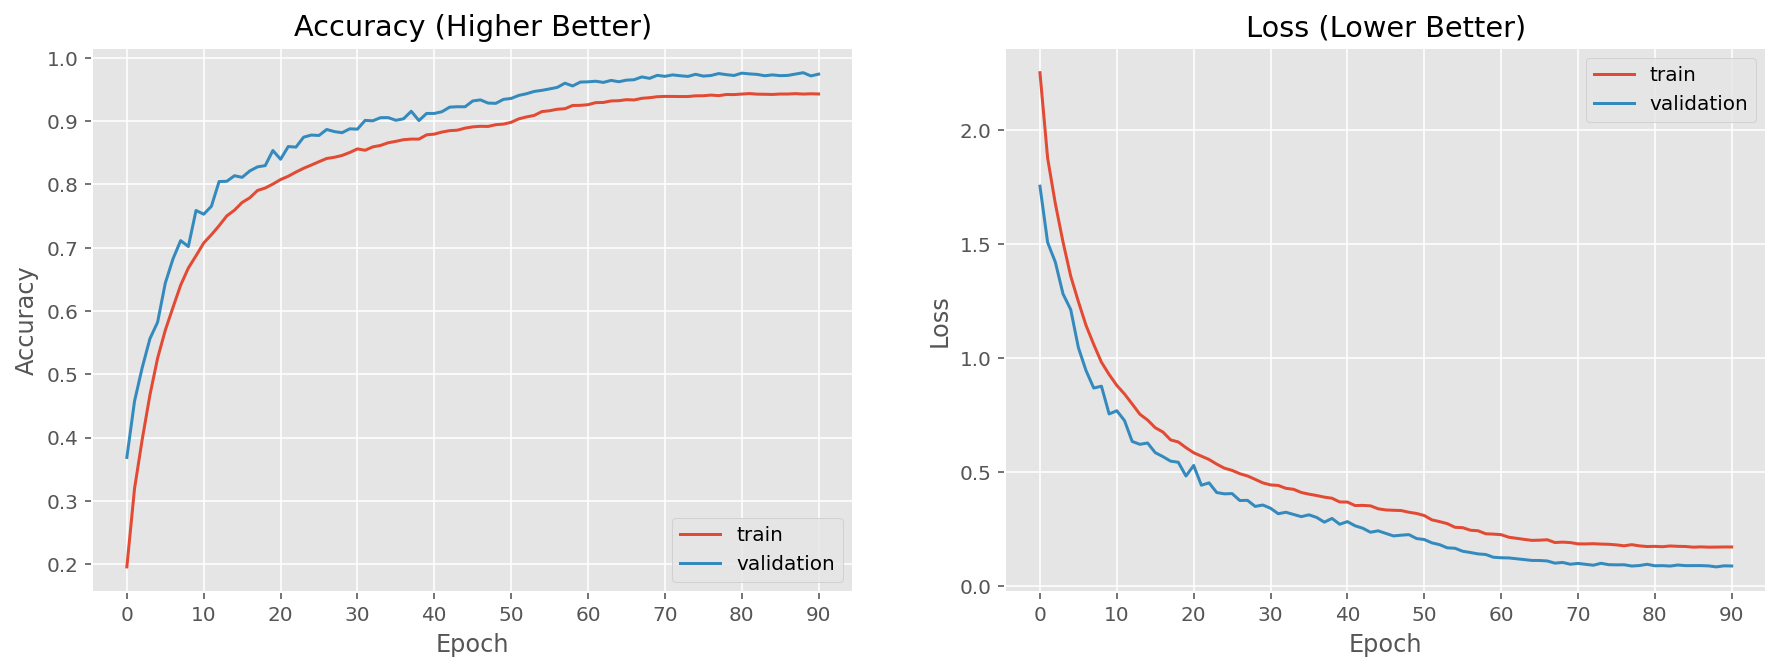

In [17]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

ax1.plot(model_log.history['accuracy'])
ax1.plot(model_log.history['val_accuracy'])
ax1.set_title('Accuracy (Higher Better)')
ax1.set(xlabel='Epoch', ylabel='Accuracy')
ax1.legend(['train', 'validation'], loc='lower right')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

ax2.plot(model_log.history['loss'])
ax2.plot(model_log.history['val_loss'])
ax2.set_title('Loss (Lower Better)')
ax2.set(xlabel='Epoch', ylabel='Loss')
ax2.legend(['train', 'validation'], loc='upper right')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

In [18]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.3485892415046692
Test accuracy: 0.9023000001907349


#### Visualizing the wrongly classified data

In [19]:
output = model.predict_classes(x_test)
print (output)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[3 8 8 ... 5 1 7]


In [20]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
ind = np.where(np.equal(output, y_test.reshape(10000))==0)

In [21]:
print(ind)

(array([  32,   35,   52,   58,   61,   78,  106,  128,  139,  145,  147,
        164,  165,  167,  169,  178,  188,  195,  211,  224,  228,  245,
        264,  287,  308,  309,  312,  332,  355,  376,  378,  384,  405,
        422,  426,  433,  439,  470,  488,  518,  526,  551,  598,  601,
        615,  618,  641,  655,  665,  675,  677,  680,  683,  685,  689,
        692,  725,  727,  731,  739,  751,  767,  770,  776,  779,  792,
        799,  810,  811,  817,  818,  831,  853,  862,  882,  888,  889,
        910,  924,  925,  943,  948,  956,  972,  982,  997, 1001, 1019,
       1032, 1034, 1040, 1042, 1049, 1050, 1072, 1088, 1095, 1126, 1129,
       1131, 1137, 1138, 1150, 1163, 1177, 1181, 1193, 1230, 1236, 1247,
       1248, 1265, 1277, 1280, 1300, 1304, 1325, 1334, 1339, 1346, 1391,
       1399, 1439, 1445, 1453, 1456, 1480, 1491, 1492, 1494, 1495, 1506,
       1527, 1529, 1536, 1538, 1547, 1552, 1577, 1605, 1620, 1644, 1675,
       1681, 1684, 1685, 1715, 1718, 1721, 1731, 1

In [22]:
err_x = x_test[ind[0]]
err_y = output[ind[0]]


In [23]:
print (err_x.shape)

(977, 32, 32, 3)


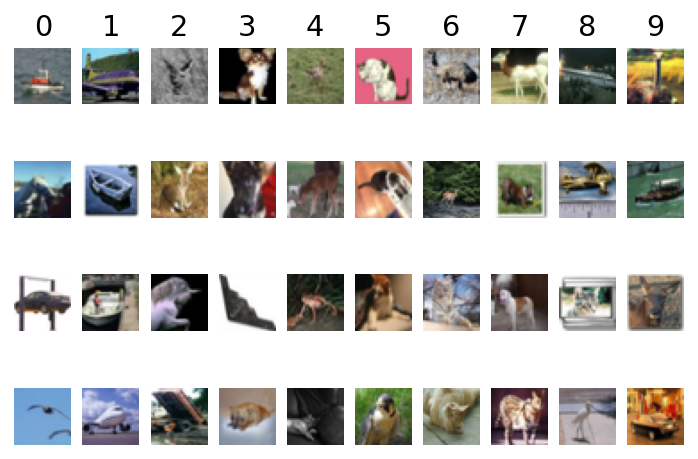

In [24]:
examples_per_class = 4
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

for cls, cls_name in enumerate(classes):
  idxs = np.where(cls == err_y)
  idxs = np.random.choice(idxs[0], examples_per_class, replace=False)
  for i, idx in enumerate(idxs):
    plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
    plt.imshow(err_x[idx].astype('uint8'), cmap = 'gray')
    plt.axis('off')
    if i == 0:
      plt.title(cls_name)